
Running MCMC sampling...


MCMC Sampling: 100%|██████████| 30000/30000 [01:02<00:00, 482.74it/s]


MCMC acceptance rate: 0.7189

Running Variational Inference...
Starting VI optimization...
VI optimization complete. Final ELBO: -2.5326
Optimized mean: [-2.55433598e-08 -1.07727032e-07]
Optimized std: [1.5        1.49999999]

Comparing approximation quality:
MCMC: KL Divergence = 0.3976, MSE = 0.00000000
VI: KL Divergence = 1.3870, MSE = 0.00000003

Running runtime benchmark...
Starting VI optimization...
VI optimization complete. Final ELBO: -1.9758
Optimized mean: [2.86226375e-07 3.85344442e-07]
Optimized std: [1.5 1.5]


MCMC Sampling: 100%|██████████| 30000/30000 [00:58<00:00, 513.68it/s]


VI Runtime: 0.88 seconds
MCMC Runtime: 58.81 seconds
Speedup factor (MCMC/VI): 67.04x

Method Comparison Summary:
  Method  KL Divergence           MSE  Runtime (s)
0   MCMC       0.397615  3.383107e-09    58.809481
1     VI       1.386975  3.463475e-08     0.877251


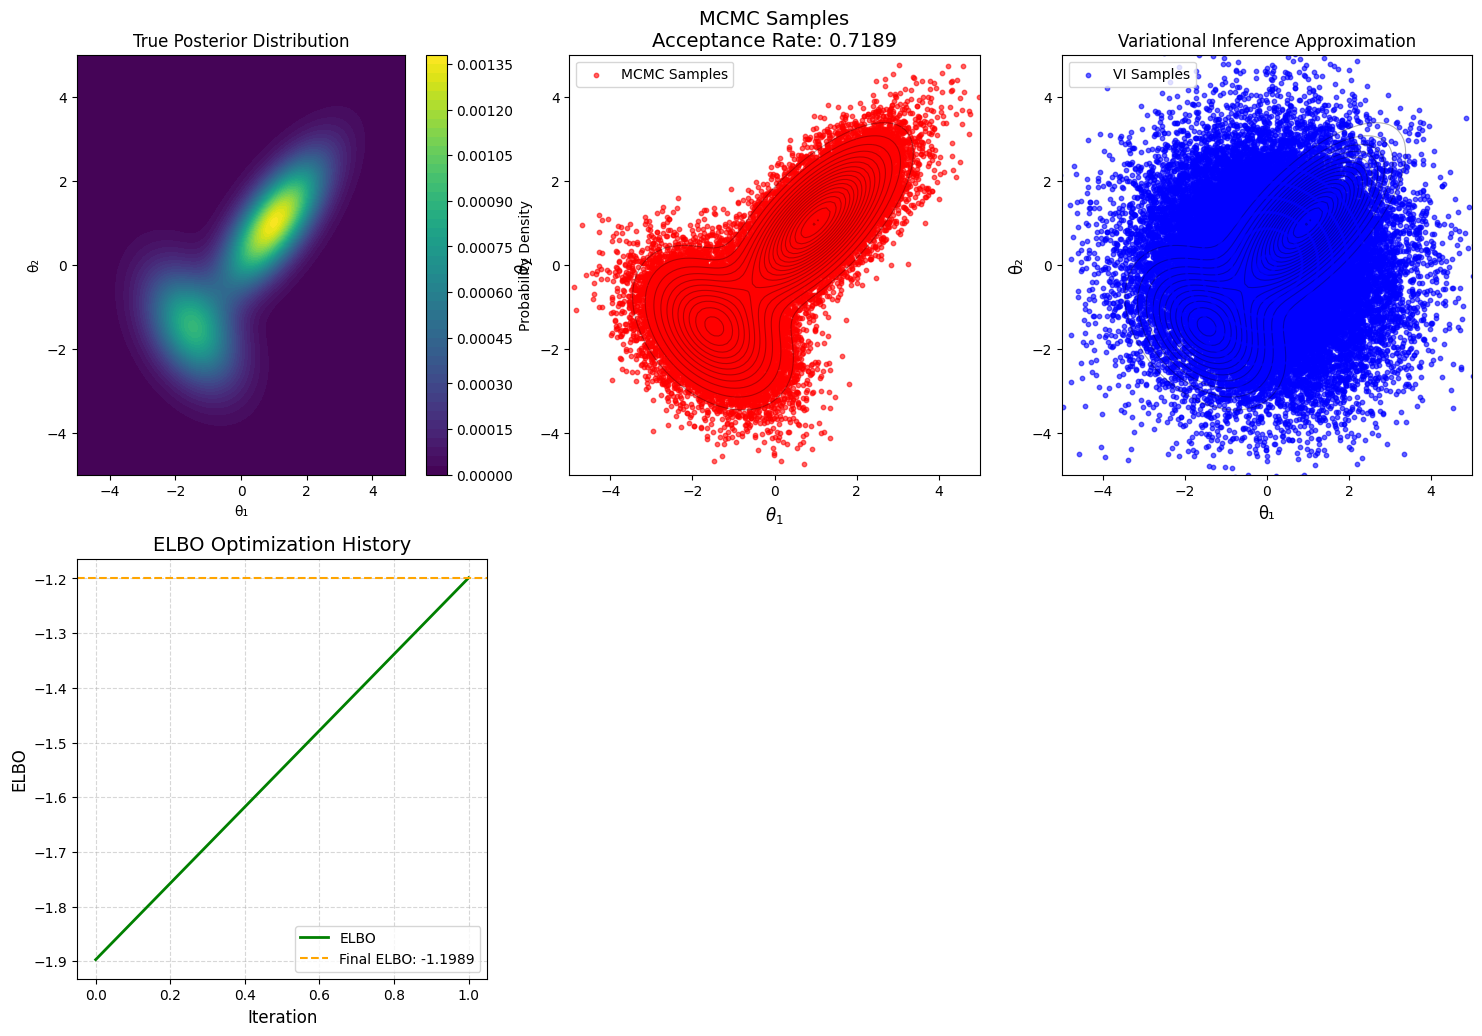

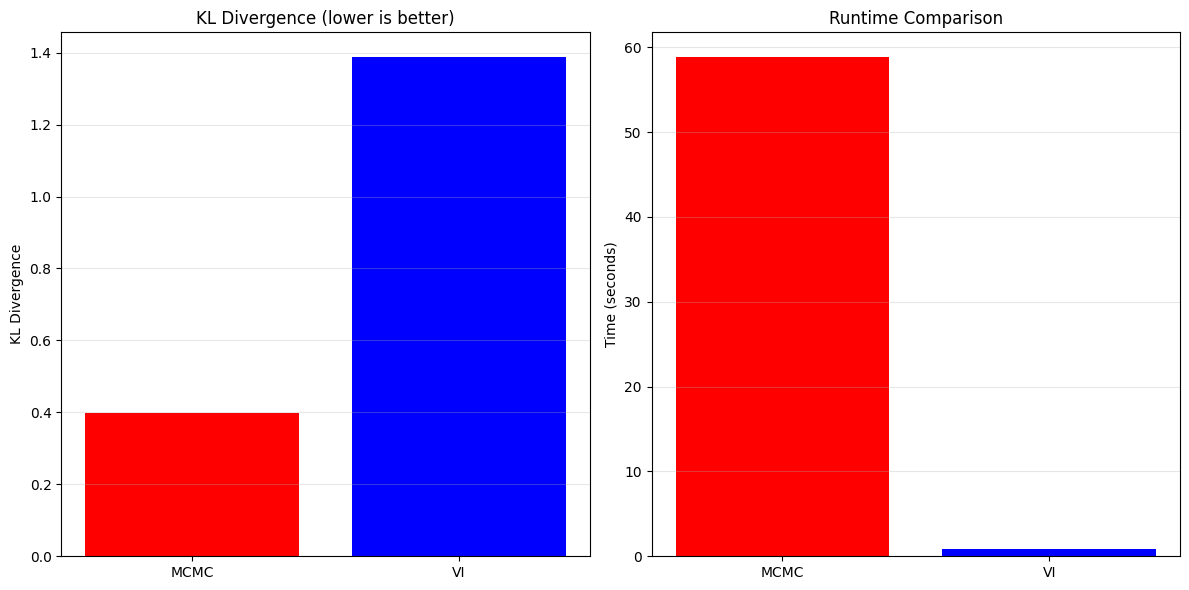


MCMC Effective Sample Size: 1417.0 (out of 30000 samples)
ESS Efficiency: 4.72%


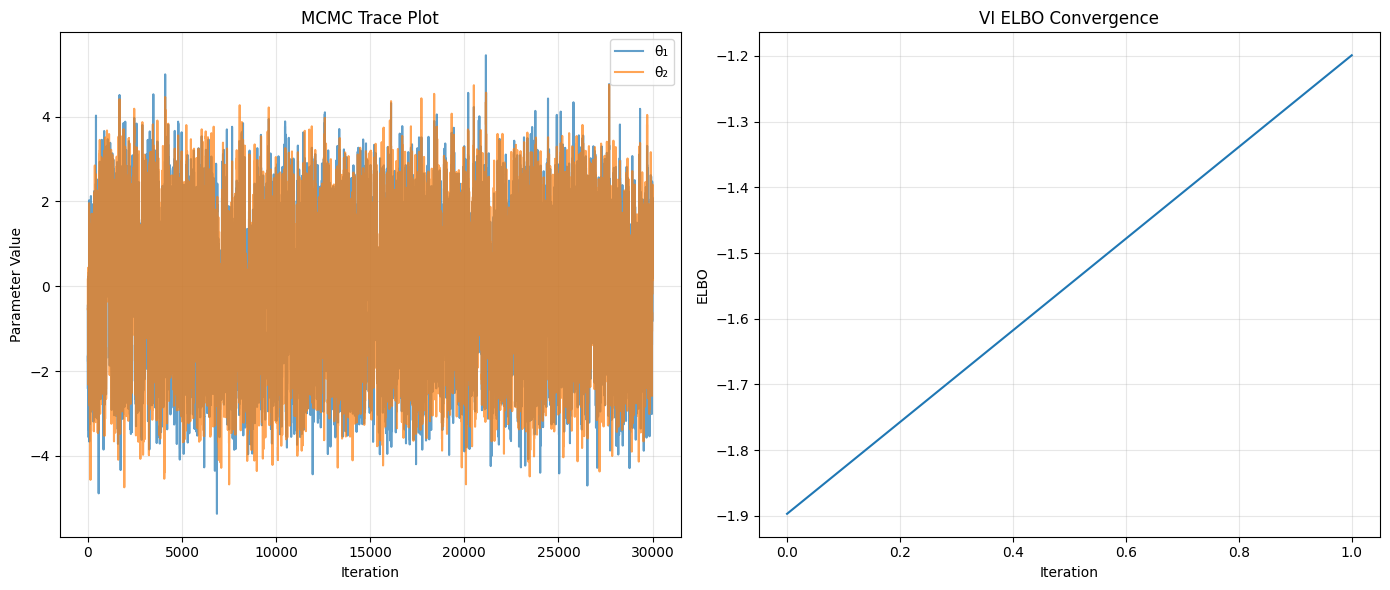


======= Summary and Conclusions =======
1. Quality of Approximation:
   - MCMC provides a better approximation (KL: 0.3976 vs 1.3870)

2. Computational Efficiency:
   - VI is 67.04x faster than MCMC
   - MCMC effective sample size: 1417.0 (4.72% efficiency)

3. Practical Considerations:
   - MCMC: More accurate for multimodal distributions, but slower and requires tuning
   - VI: Faster but may struggle with multimodal distributions
   - The choice depends on the specific requirements of your application

This comparison demonstrates the trade-offs between MCMC and VI methods
for Bayesian inference in terms of accuracy, speed, and practical usability.

Results saved to 'mcmc_vi_comparison_results.csv'

Execution complete!


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize
import pandas as pd
from matplotlib import cm
from matplotlib.colors import ListedColormap
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Define a complicated target distribution (posterior)

def target_log_pdf(theta):
    """
    Log probability of a complicated distribution (mixture of Gaussians)
    """
    mu1 = np.array([1.0, 1.0])
    cov1 = np.array([[1.0, 0.7], [0.7, 1.0]])
    mu2 = np.array([-1.5, -1.5])
    cov2 = np.array([[0.8, -0.3], [-0.3, 0.8]])

    # Add small value to diagonal elements of covariance matrices for stability
    cov1_stable = cov1.copy()
    cov2_stable = cov2.copy()
    cov1_stable[np.diag_indices_from(cov1_stable)] += 1e-6
    cov2_stable[np.diag_indices_from(cov2_stable)] += 1e-6

    try:
        log_p1 = stats.multivariate_normal.logpdf(theta, mean=mu1, cov=cov1_stable)
        log_p2 = stats.multivariate_normal.logpdf(theta, mean=mu2, cov=cov2_stable)

        # Log-sum-exp trick for numerical stability
        max_log = max(log_p1, log_p2)
        weights = np.array([0.6, 0.4])
        log_p = max_log + np.log(weights[0] * np.exp(log_p1 - max_log) + weights[1] * np.exp(log_p2 - max_log))
    except Exception as e:
        log_p = -np.inf

    return log_p

def target_pdf(theta):
    """Non-log version of the PDF"""
    log_p = target_log_pdf(theta)
    if np.isfinite(log_p):
        return np.exp(log_p)
    else:
        return 0.0

# Create a grid for visualization
grid_resolution = 100
x = np.linspace(-5, 5, grid_resolution)
y = np.linspace(-5, 5, grid_resolution)
X, Y = np.meshgrid(x, y)

# Calculate density at each grid point
Z = np.zeros((grid_resolution, grid_resolution))
for i in range(grid_resolution):
    for j in range(grid_resolution):
        Z[i, j] = target_pdf([X[i, j], Y[i, j]])

# Normalize to ensure it's a proper probability distribution
Z = Z / np.sum(Z)

# MCMC Sampling (Metropolis-Hastings)
def mcmc_sampling(n_samples, burnin=1000, thin=5):
    """
    Perform MCMC sampling using the Metropolis-Hastings algorithm.
    """
    samples = []
    theta_current = np.array([0.0, 0.0])  # Starting point
    proposal_std = 0.5  # Step size for proposal
    accepted = 0
    total = 0

    # Burn-in phase
    for _ in range(burnin):
        theta_proposed = theta_current + np.random.normal(0, proposal_std, 2)
        log_current = target_log_pdf(theta_current)
        log_proposed = target_log_pdf(theta_proposed)
        log_acceptance_ratio = log_proposed - log_current

        if np.log(np.random.uniform()) < log_acceptance_ratio:
            theta_current = theta_proposed
            accepted += 1
        total += 1

    # Sampling phase with thinning
    with tqdm(total=n_samples, desc="MCMC Sampling") as pbar:
        while len(samples) < n_samples:
            for _ in range(thin):
                theta_proposed = theta_current + np.random.normal(0, proposal_std, 2)
                log_current = target_log_pdf(theta_current)
                log_proposed = target_log_pdf(theta_proposed)
                log_acceptance_ratio = log_proposed - log_current

                if np.log(np.random.uniform()) < log_acceptance_ratio:
                    theta_current = theta_proposed
                    accepted += 1
                total += 1

            samples.append(theta_current.copy())
            pbar.update(1)

    acceptance_rate = accepted / total
    return np.array(samples), acceptance_rate

# Variational Inference
class GaussianVariationalDistribution:
    """
    Gaussian variational distribution with diagonal covariance.
    """
    def __init__(self, dim=2):
        self.mean = np.zeros(dim)
        self.log_std = np.zeros(dim)  # Log standard deviation for numerical stability

    def sample(self, n_samples):
        """Draw samples from the variational distribution."""
        std = np.exp(self.log_std)
        return np.random.normal(0, 1, (n_samples, len(self.mean))) * std + self.mean

    def log_prob(self, x):
        """Compute log probability under the variational distribution."""
        std = np.exp(self.log_std)
        return np.sum(stats.norm.logpdf(x, loc=self.mean, scale=std), axis=-1)

    def entropy(self):
        """Compute entropy of the Gaussian distribution."""
        return np.sum(self.log_std + 0.5 * np.log(2 * np.pi * np.e))

    def parameters(self):
        """Return flattened parameters for optimization."""
        return np.concatenate([self.mean, self.log_std])

    def set_parameters(self, params):
        """Set parameters from flattened array."""
        dim = len(self.mean)
        self.mean = params[:dim]
        self.log_std = params[dim:]

# Fix 2: Modify variational objective function for better stability
def variational_objective(params, q_dist, n_samples=100):
    """
    Compute negative ELBO (Evidence Lower Bound) for optimization.
    """
    q_dist.set_parameters(params)
    samples = q_dist.sample(n_samples)

    # Calculate log probability under the true posterior
    log_p_values = np.array([target_log_pdf(sample) for sample in samples])

    # Filter out invalid values
    valid_indices = np.isfinite(log_p_values)
    if not np.any(valid_indices):
        return 1e6  # Return a large value if all samples give -inf

    # Use only valid samples
    valid_samples = samples[valid_indices]
    log_p_values = log_p_values[valid_indices]

    # Calculate log probability under the variational distribution
    log_q_values = q_dist.log_prob(valid_samples)

    # Compute ELBO
    elbo = np.mean(log_p_values - log_q_values)
    return -elbo


def run_variational_inference(n_iterations=1000):
    """Run variational inference optimization with improved stability"""
    # Initialize variational distribution with slightly better starting point
    q_dist = GaussianVariationalDistribution(dim=2)
    q_dist.mean = np.array([0.0, 0.0])  # Start at origin
    q_dist.log_std = np.log(np.array([1.5, 1.5]))  # Start with wider variance
    
    # Initial parameters
    initial_params = q_dist.parameters()
    
    # Track ELBO during optimization
    elbo_history = []
    best_elbo = -np.inf
    best_params = initial_params.copy()
    
    # Define callback to track progress
    def callback(params):
        q_dist.set_parameters(params)
        elbo = -variational_objective(params, q_dist, n_samples=50)
        elbo_history.append(elbo)
        
        nonlocal best_elbo, best_params
        if np.isfinite(elbo) and elbo > best_elbo:
            best_elbo = elbo
            best_params = params.copy()
            
        if len(elbo_history) % 50 == 0:
            print(f"Iteration {len(elbo_history)}: ELBO = {elbo:.4f}")
    
    # Optimize variational parameters with bounds to prevent extreme values
    print("Starting VI optimization...")
    bounds = [(None, None)] * 2 + [(-10, 10)] * 2  # Bounds for log_std to prevent extreme values
    
    try:
        result = optimize.minimize(
            variational_objective, 
            initial_params,
            args=(q_dist, 50),  # Use 50 samples per objective evaluation
            method='L-BFGS-B',
            bounds=bounds,
            callback=callback,
            options={'maxiter': n_iterations, 'maxfun': n_iterations * 2}
        )
        
        # If optimization gave NaN, use the best parameters found during optimization
        if not np.isfinite(result.fun):
            print("Warning: Optimization resulted in NaN. Using best parameters found.")
            q_dist.set_parameters(best_params)
            final_elbo = best_elbo
        else:
            # Set final parameters
            q_dist.set_parameters(result.x)
            final_elbo = -result.fun
    except Exception as e:
        print(f"Optimization failed: {str(e)}")
        print("Using best parameters found so far.")
        q_dist.set_parameters(best_params)
        final_elbo = best_elbo
    
    print(f"VI optimization complete. Final ELBO: {final_elbo:.4f}")
    print(f"Optimized mean: {q_dist.mean}")
    print(f"Optimized std: {np.exp(q_dist.log_std)}")
    
    return q_dist, elbo_history

# Run MCMC and VI
n_samples = 30000
print("\nRunning MCMC sampling...")
mcmc_samples, mcmc_rate = mcmc_sampling(n_samples)
print(f"MCMC acceptance rate: {mcmc_rate:.4f}")

print("\nRunning Variational Inference...")
vi_dist, elbo_history = run_variational_inference(n_iterations=500)

# Generate samples from the variational distribution
vi_samples = vi_dist.sample(n_samples)

# Visualizations

# Create custom colormap for better visualization
colors = plt.cm.viridis(np.linspace(0, 1, 256))
mymap = ListedColormap(colors)

# Visualize the true posterior and approximations
plt.figure(figsize=(18, 12))

# True Distribution
plt.subplot(2, 3, 1)
plt.contourf(X, Y, Z, 50, cmap=mymap)
plt.colorbar(label='Probability Density')
plt.title('True Posterior Distribution')
plt.xlabel('θ₁')
plt.ylabel('θ₂')

# MCMC Samples
plt.subplot(2, 3, 2)
plt.scatter(mcmc_samples[:, 0], mcmc_samples[:, 1], s=10, c='red', alpha=0.6, label='MCMC Samples')
plt.contour(X, Y, Z, 20, colors='black', alpha=0.3, linewidths=0.8)
plt.title(f'MCMC Samples\nAcceptance Rate: {mcmc_rate:.4f}', fontsize=14)
plt.xlabel(r'$\theta_1$', fontsize=12)
plt.ylabel(r'$\theta_2$', fontsize=12)
plt.legend(fontsize=10)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# VI Approximation
plt.subplot(2, 3, 3)
plt.scatter(vi_samples[:, 0], vi_samples[:, 1], s=10, c='blue', alpha=0.6, label='VI Samples')
plt.contour(X, Y, Z, 20, colors='black', alpha=0.3, linewidths=0.8)
plt.title('Variational Inference Approximation', fontsize=14)
plt.xlabel(r'$\theta_1$', fontsize=12)
plt.ylabel(r'$\theta_2$', fontsize=12)
plt.legend(fontsize=10)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# Draw the learned Gaussian approximation contours
mean = vi_dist.mean
cov = np.diag(np.exp(vi_dist.log_std) ** 2)
x, y = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.dstack((x, y))
rv = stats.multivariate_normal(mean, cov)
plt.contour(x, y, rv.pdf(pos), colors='blue', alpha=0.7, linewidths=2)

plt.title('Variational Inference Approximation')
plt.xlabel('θ₁')
plt.ylabel('θ₂')
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# ELBO History
plt.subplot(2, 3, 4)
plt.plot(elbo_history, color='green', linewidth=2, label='ELBO')
plt.axhline(y=elbo_history[-1], color='orange', linestyle='--', linewidth=1.5, label=f'Final ELBO: {elbo_history[-1]:.4f}')
plt.title('ELBO Optimization History', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('ELBO', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

# Compute true marginal along θ₁
true_x_marginal = np.sum(Z, axis=0)
true_x_marginal = true_x_marginal / np.sum(true_x_marginal)  # Normalize

# # Density Comparison - θ₁ Marginal
# plt.subplot(2, 3, 5)
# sns.kdeplot(mcmc_samples[:, 0], label='MCMC', color='red', linestyle='--', linewidth=2)
# sns.kdeplot(vi_samples[:, 0], label='VI', color='blue', linestyle='-.', linewidth=2)
# plt.plot(x, true_x_marginal * len(x) / np.sum(true_x_marginal), 'k-', linewidth=2, label='True Marginal')
# plt.title(r'$\theta_1$ Marginal Distribution Comparison', fontsize=14)
# plt.xlabel(r'$\theta_1$', fontsize=12)
# plt.ylabel('Density', fontsize=12)
# plt.legend(fontsize=10)

# # Compute true marginal along θ₂
# true_y_marginal = np.sum(Z, axis=1)
# true_y_marginal = true_y_marginal / np.sum(true_y_marginal)  # Normalize

# # Density Comparison - θ₂ Marginal
# plt.subplot(2, 3, 6)
# sns.kdeplot(mcmc_samples[:, 1], label='MCMC', color='red', linestyle='--', linewidth=2)
# sns.kdeplot(vi_samples[:, 1], label='VI', color='blue', linestyle='-.', linewidth=2)
# plt.plot(y, true_y_marginal * len(y) / np.sum(true_y_marginal), 'k-', linewidth=2, label='True Marginal')
# plt.title(r'$\theta_2$ Marginal Distribution Comparison', fontsize=14)
# plt.xlabel(r'$\theta_2$', fontsize=12)
# plt.ylabel('Density', fontsize=12)
# plt.legend(fontsize=10)

# plt.tight_layout()
# plt.savefig('mcmc_vs_vi_comparison.png', dpi=300)
# plt.show()

# Calculate metrics for comparison
def calculate_kl_divergence(samples, true_dist, grid_resolution=100):
    """Calculate approximate KL divergence from samples to true distribution with improved stability"""
    # Calculate histogram of samples
    hist, x_edges, y_edges = np.histogram2d(
        samples[:, 0], samples[:, 1], 
        bins=grid_resolution, 
        range=[[-5, 5], [-5, 5]], 
        density=True
    )
    
    # Replace zeros with small value to avoid division by zero or log(0)
    eps = 1e-10
    hist_safe = np.maximum(hist, eps)
    Z_safe = np.maximum(true_dist, eps)
    
    # Normalize both distributions to ensure they sum to 1
    hist_safe = hist_safe / np.sum(hist_safe)
    Z_safe = Z_safe / np.sum(Z_safe)
    
    # Calculate KL divergence: ∑ P(x) * log(P(x)/Q(x))
    # Only include points where true_dist is non-negligible
    mask = Z_safe > eps * 10
    log_ratio = np.log(Z_safe[mask] / hist_safe[mask])
    
    # Handle any remaining numerical issues
    valid_indices = np.isfinite(log_ratio)
    if not np.any(valid_indices):
        return np.inf, np.inf  # Return inf if calculation fails
    
    kl_div = np.sum(Z_safe[mask][valid_indices] * log_ratio[valid_indices])
    
    # Calculate Mean Squared Error
    mse = np.mean((Z_safe - hist_safe) ** 2)
    
    return kl_div, mse

# Calculate VI runtime vs MCMC runtime
def benchmark_runtime(n_iterations=1000, n_samples=1000):
    """Compare runtime of VI vs MCMC"""
    import time
    
    # Time VI
    vi_start = time.time()
    vi_dist, _ = run_variational_inference(n_iterations=n_iterations)
    vi_end = time.time()
    vi_time = vi_end - vi_start
    
    # Time MCMC
    mcmc_start = time.time()
    mcmc_samples, _ = mcmc_sampling(n_samples)
    mcmc_end = time.time()
    mcmc_time = mcmc_end - mcmc_start
    
    return {'VI Time': vi_time, 'MCMC Time': mcmc_time, 'Speedup': mcmc_time/vi_time}

# Calculate metrics
kl_mcmc, mse_mcmc = calculate_kl_divergence(mcmc_samples, Z, grid_resolution)
kl_vi, mse_vi = calculate_kl_divergence(vi_samples, Z, grid_resolution)

print("\nComparing approximation quality:")
print(f"MCMC: KL Divergence = {kl_mcmc:.4f}, MSE = {mse_mcmc:.8f}")
print(f"VI: KL Divergence = {kl_vi:.4f}, MSE = {mse_vi:.8f}")

# Run the runtime benchmark
print("\nRunning runtime benchmark...")
runtime_results = benchmark_runtime(n_iterations=300, n_samples=30000)
print(f"VI Runtime: {runtime_results['VI Time']:.2f} seconds")
print(f"MCMC Runtime: {runtime_results['MCMC Time']:.2f} seconds")
print(f"Speedup factor (MCMC/VI): {runtime_results['Speedup']:.2f}x")

# Create a summary table
comparison_data = {
    'Method': ['MCMC', 'VI'],
    'KL Divergence': [kl_mcmc, kl_vi],
    'MSE': [mse_mcmc, mse_vi],
    'Runtime (s)': [runtime_results['MCMC Time'], runtime_results['VI Time']]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nMethod Comparison Summary:")
print(comparison_df)

# Plot the comparison metrics
plt.figure(figsize=(12, 6))

# KL Divergence
plt.subplot(1, 2, 1)
plt.bar(['MCMC', 'VI'], [kl_mcmc, kl_vi], color=['red', 'blue'])
plt.title('KL Divergence (lower is better)')
plt.ylabel('KL Divergence')
plt.grid(axis='y', alpha=0.3)

# Runtime
plt.subplot(1, 2, 2)
plt.bar(['MCMC', 'VI'], [runtime_results['MCMC Time'], runtime_results['VI Time']], color=['red', 'blue'])
plt.title('Runtime Comparison')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('mcmc_vi_metrics_comparison.png', dpi=300)
plt.show()

# Calculate effective sample size for MCMC
def calculate_effective_sample_size(samples):
    """Calculate effective sample size using autocorrelation"""
    n_samples = len(samples)
    
    # Calculate autocorrelation for each dimension
    ess_per_dim = []
    for dim in range(samples.shape[1]):
        # Calculate autocorrelation
        acf = np.correlate(samples[:, dim] - samples[:, dim].mean(), 
                           samples[:, dim] - samples[:, dim].mean(), 
                           mode='full')
        acf = acf[n_samples-1:] / acf[n_samples-1]
        
        # Find where autocorrelation drops below 0.05
        cutoff = np.where(acf < 0.05)[0]
        if len(cutoff) > 0:
            max_lag = cutoff[0]
        else:
            max_lag = min(100, len(acf) // 4)  # Use reasonable default if no cutoff found
        
        # Compute ESS using cutoff autocorrelation
        ess = n_samples / (1 + 2 * np.sum(acf[1:max_lag]))
        ess_per_dim.append(ess)
    
    return np.min(ess_per_dim)  # Return the minimum ESS across dimensions

# Calculate effective sample size for MCMC
mcmc_ess = calculate_effective_sample_size(mcmc_samples)
print(f"\nMCMC Effective Sample Size: {mcmc_ess:.1f} (out of {n_samples} samples)")
print(f"ESS Efficiency: {mcmc_ess/n_samples:.2%}")

# Visualize samples over iterations (convergence)
plt.figure(figsize=(14, 6))

# MCMC trace plot
plt.subplot(1, 2, 1)
plt.plot(mcmc_samples[:, 0], label='θ₁', alpha=0.7)
plt.plot(mcmc_samples[:, 1], label='θ₂', alpha=0.7)
plt.title('MCMC Trace Plot')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()
plt.grid(True, alpha=0.3)

# VI ELBO convergence
plt.subplot(1, 2, 2)
plt.plot(elbo_history)
plt.title('VI ELBO Convergence')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mcmc_vi_convergence.png', dpi=300)
plt.show()

# Summary and conclusions
print("\n======= Summary and Conclusions =======")
print("1. Quality of Approximation:")
if kl_mcmc < kl_vi:
    print(f"   - MCMC provides a better approximation (KL: {kl_mcmc:.4f} vs {kl_vi:.4f})")
else:
    print(f"   - VI provides a better approximation (KL: {kl_vi:.4f} vs {kl_mcmc:.4f})")

print("\n2. Computational Efficiency:")
print(f"   - VI is {runtime_results['Speedup']:.2f}x faster than MCMC")
print(f"   - MCMC effective sample size: {mcmc_ess:.1f} ({mcmc_ess/n_samples:.2%} efficiency)")

print("\n3. Practical Considerations:")
print("   - MCMC: More accurate for multimodal distributions, but slower and requires tuning")
print("   - VI: Faster but may struggle with multimodal distributions")
print("   - The choice depends on the specific requirements of your application")

print("\nThis comparison demonstrates the trade-offs between MCMC and VI methods")
print("for Bayesian inference in terms of accuracy, speed, and practical usability.")

# Optional: Save results to file
comparison_df.to_csv('mcmc_vi_comparison_results.csv', index=False)
print("\nResults saved to 'mcmc_vi_comparison_results.csv'")

if __name__ == "__main__":
    print("\nExecution complete!")